In [352]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import torch
import torch.nn as nn
from torch import optim
import tqdm
import copy
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
print(f"Using GPU: {torch.cuda.is_available()}")

Using GPU: True


In [353]:
# define our dataframes
df_train = pd.read_csv(filepath_or_buffer='./data/train.csv')

# check it out
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [354]:
# lets drop some features we will for sure not need
drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']

# drop the features we don't need
df_train.drop(labels=drop_columns,axis=1,inplace=True)
print(f"Dropped {drop_columns}")

df_train.head()

Dropped ['PassengerId', 'Name', 'Ticket', 'Cabin']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [356]:
# only a small amount of embarked samples are N/A so lets drop these samples
df_train.dropna(axis='index',subset='Embarked',inplace=True)
print(f"Dropped rows with column {'Embarked'} == NaN.")

Dropped rows with column Embarked == NaN.


In [357]:
# lets clean some of our data
def clean_gender(x):
    if x == 'female':
        return 1
    elif x == 'male':
        return 0
    else:
        return x
    
def clean_classes(x):
    if x == 1:
        return 3
    elif x == 2:
        return 2
    elif x == 3:
        return 1
    else:
        return x

def clean_embarked(x):
    if x == "C":
        return 0
    elif x == "Q":
        return 1
    elif x == "S":
        return 2
    else:
        return x
    
df_clean = df_train.copy()
df_clean['Sex'] = df_clean['Sex'].apply(func=clean_gender)
df_clean['Pclass'] = df_clean['Pclass'].apply(func=clean_classes)
df_clean['Embarked'] = df_clean['Embarked'].apply(func=clean_embarked)
df_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,0,22.0,1,0,7.2500,2
1,1,3,1,38.0,1,0,71.2833,0
2,1,1,1,26.0,0,0,7.9250,2
3,1,3,1,35.0,1,0,53.1000,2
4,0,1,0,35.0,0,0,8.0500,2


<Axes: >

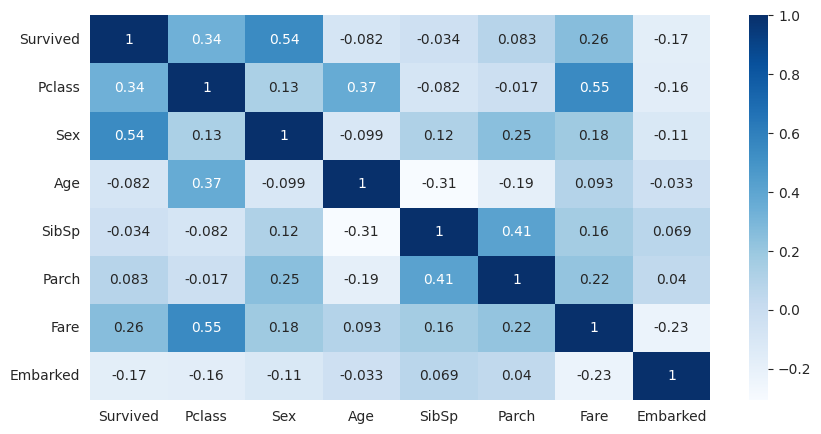

In [359]:
# check the relationship among variables
correlation = df_clean.corr()
plt.figure(figsize=(10,5))
sns.heatmap(data=correlation,annot=True,cmap='Blues')

In [367]:
# we can see that almost 20% of our age values are NaN, we don't want to drop these, so lets fill them with mean age
percentage_nan = df_clean['Age'].isna().sum() / len(df_clean)
print(percentage_nan * 100)

19.910011248593925


In [368]:
# lets fill our age values with mean age
df_clean['Age'].fillna(value=df_clean['Age'].mean(),inplace=True)

In [370]:
# check for null values
df_clean.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [371]:
df_inputs = df_clean.drop(labels='Survived', axis='columns')
df_targets = df_clean[['Survived']]

In [170]:
# --------------------------- TRAINING -----------------------------------------------------#

In [372]:
X = torch.tensor(data=df_inputs.values,dtype=torch.float32)
Y = torch.tensor(data=df_targets.values,dtype=torch.float32)
print(X.shape)
print(Y.shape)

torch.Size([889, 7])
torch.Size([889, 1])


In [374]:
class Deep(nn.Module):
    def __init__(self,input_features_ct):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_features_ct, out_features=60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(in_features=60, out_features=60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(in_features=60, out_features=60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(in_features=60, out_features=1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1.forward(input=self.layer1.forward(input=x))
        x = self.act2.forward(input=self.layer2.forward(input=x))
        x = self.act3.forward(input=self.layer3.forward(input=x))
        x = self.sigmoid.forward(input=self.output.forward(input=x))
        return x
    
myNet = Deep(input_features_ct=X.shape[1])

In [376]:
training_parameters = {
    'epochs': 300,
    'batch_size': 32,
    'loss_fn': nn.BCELoss(),
    'optimizer': optim.Adam(params=myNet.parameters(),lr=0.001),
}

scores = []
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, shuffle=True)
kfold = StratifiedKFold(n_splits=5,shuffle=True)

for train, test in kfold.split(X=X_train,y=y_train):
    acc = train_model(myNet, training_parameters, X_train[train], y_train[train], X_train[test], y_train[test])
    print(f"Accuracy: {acc}")
    scores.append(acc)


Accuracy: 0.7839999794960022
Accuracy: 0.8479999899864197
Accuracy: 0.8467742204666138
Accuracy: 0.8629032373428345
Accuracy: 0.8225806355476379


In [377]:
print(scores)
acc = np.mean(scores)
std = np.std(scores)
print(f"mean accuracy: {acc}%")
print(f"std: {std}")

[0.7839999794960022, 0.8479999899864197, 0.8467742204666138, 0.8629032373428345, 0.8225806355476379]
mean accuracy: 0.8328516125679016%
std: 0.027634715571073967


In [375]:
def train_model(model,params,X_train,Y_train,X_test,Y_test):
    # loss function and optimizer
    loss_fn = params['loss_fn']
    optimizer = params['optimizer']
    
    # define epochs and batch sizes
    epochs = params['epochs']
    batch_size = params['batch_size']
    batch_start = torch.arange(start=0,end=len(X_train),step=batch_size)

    # cache the best model
    best_acc = -np.inf
    best_weights = None
    
    for epoch in range(epochs):
        model.train()
        with tqdm.tqdm(iterable=batch_start,mininterval=5,disable=True) as bar:
            bar.set_description(desc=f"Epoch {epoch}")
            for start in bar:
                x_batch = X_train[start:start+batch_size]
                y_batch = Y_train[start:start+batch_size]
                
                y_pred = model.forward(x_batch)
                loss = loss_fn(y_pred,y_batch)
                
                optimizer.zero_grad()
                loss.backward()
                
                optimizer.step()
                
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(acc),
                    acc=float(acc)
                )
                
        model.eval()
        y_pred = model.forward(X_test)
        acc = (y_pred.round() == Y_test).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_weights)
    return best_acc
        

In [378]:
# now lets test our model
df_test = pd.read_csv(filepath_or_buffer='./data/test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [379]:
# drop unnecessary features
df_test.drop(labels=['Name', 'Cabin','Ticket'],axis='columns',inplace=True)

In [381]:
# we have a single NaN fare
df_test.at[152, 'Fare'] = df_test.Fare.describe()['75%']

In [382]:
df_test['Pclass'] = df_test['Pclass'].apply(func=clean_classes)
df_test['Sex'] = df_test['Sex'].apply(func=clean_gender)
df_test['Embarked'] = df_test['Embarked'].apply(func=clean_embarked)
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,1,0,34.5,0,0,7.8292,1
1,893,1,1,47.0,1,0,7.0000,2
2,894,2,0,62.0,0,0,9.6875,1
3,895,1,0,27.0,0,0,8.6625,2
4,896,1,1,22.0,1,1,12.2875,2


In [383]:
df_test['Age'].fillna(value=df_test.Age.mean(), inplace=True)

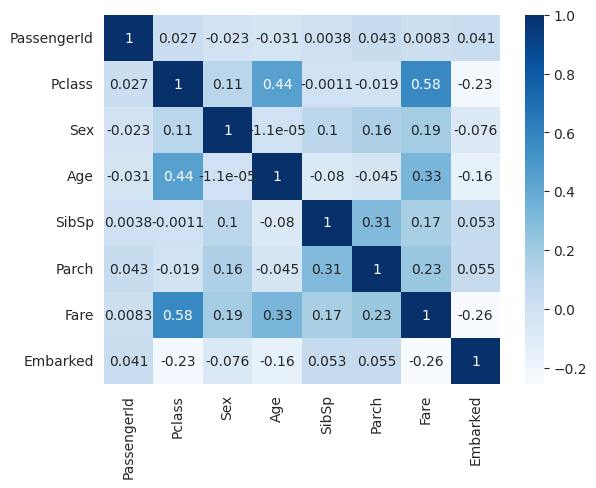

In [384]:
correlation = df_test.corr()
heatmap = sns.heatmap(data=correlation,annot=True,cmap='Blues')

In [385]:
passengerIds = []
predictions = []
for row_index, sample in df_test.iterrows():
    passengerId = sample['PassengerId']
    x_sample = sample.drop(labels='PassengerId')
    x = torch.tensor(data=x_sample.values,dtype=torch.float32)
    y = myNet.forward(x=x)
    passengerIds.append(int(passengerId))
    if y <= 0.50:
        predictions.append(0)
    else:
        predictions.append(1)
        
df_res = pd.DataFrame(data={'PassengerId':passengerIds, 'Survived':predictions})
df_res.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [386]:
df_res.to_csv(path_or_buf='./res.csv',index=False)